In [139]:
import numpy as np
import pandas as pd
from pathlib import Path
import hvplot.pandas
from finta import TA

In [140]:
path = Path('Data/daily_voo_stock_data.csv')
voo_df = pd.read_csv(path, index_col='Date')

In [141]:
voo_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-11-21,183.339916,184.187145,183.212376,184.150711,2641300,0.0,0
2016-11-22,184.551585,184.688231,183.813673,184.487808,2773400,0.0,0
2016-11-23,184.150708,184.669988,183.813640,184.651764,1466300,0.0,0
2016-11-25,185.007058,185.389679,184.897742,185.389679,1843100,0.0,0
2016-11-28,184.997937,185.271227,184.342012,184.515091,2193000,0.0,0


In [142]:
short_window = 10
long_window = 50

voo_df['Short_VAMA'] = TA.VAMA(voo_df, short_window)
voo_df['Long_VAMA'] = TA.VAMA(voo_df, long_window)
voo_df['VWAP'] = TA.VWAP(voo_df)
voo_df['MOM'] = TA.MOM(voo_df)

In [143]:
voo_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Short_VAMA,Long_VAMA,VWAP,MOM
Date,,,,,,,,,,,
2016-11-21,183.339916,184.187145,183.212376,184.150711,2641300,0.0,0,NaN,NaN,183.850077,NaN
2016-11-22,184.551585,184.688231,183.813673,184.487808,2773400,0.0,0,NaN,NaN,184.095844,NaN
2016-11-23,184.150708,184.669988,183.813640,184.651764,1466300,0.0,0,NaN,NaN,184.156068,NaN
2016-11-25,185.007058,185.389679,184.897742,185.389679,1843100,0.0,0,NaN,NaN,184.382045,NaN
2016-11-28,184.997937,185.271227,184.342012,184.515091,2193000,0.0,0,NaN,NaN,184.447812,NaN


In [144]:
voo_df.dropna(inplace=True)

In [145]:
voo_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Short_VAMA,Long_VAMA,VWAP,MOM
Date,,,,,,,,,,,
2017-04-13,197.547073,198.228593,196.598480,196.598480,1806800,0.0,0,198.557703,198.337108,193.078025,-3.131271
2017-04-17,197.086588,198.329897,196.902398,198.320679,1746900,0.0,0,198.490184,198.431920,193.114689,-0.930176
2017-04-18,197.593138,198.228607,197.068181,197.777328,2695900,0.0,0,198.321817,198.606556,193.168308,-1.224869
2017-04-19,198.293091,198.652267,197.141884,197.344498,2032400,0.0,0,198.122040,198.644967,193.208095,-1.768204
2017-04-20,197.989115,199.388986,197.657567,198.956131,2734000,0.0,0,198.203202,198.713878,193.271644,0.451279


In [146]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [147]:
# window of past 'x' days for features
window_size = 15

# Column indexes for features and targets
feature_column = [7, 9]
target_column = 3
X, y = window_data(voo_df, window_size, feature_column, target_column)

nsamples, nx, ny = X.shape
X = X.reshape((nsamples, nx*ny))

In [148]:
# Use 70% of the data for training and the remaineder for testing

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [149]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [150]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [152]:
# Build the LSTM model. 
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [153]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [154]:
# Summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 10)            480       
                                                                 
 dropout_15 (Dropout)        (None, 30, 10)            0         
                                                                 
 lstm_16 (LSTM)              (None, 30, 10)            840       
                                                                 
 dropout_16 (Dropout)        (None, 30, 10)            0         
                                                                 
 lstm_17 (LSTM)              (None, 10)                840       
                                                                 
 dropout_17 (Dropout)        (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [155]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, 
          y_train, 
          epochs=20, 
          shuffle=False, 
          batch_size=10, 
          verbose=1)

Epoch 1/20
80/80 [==============================] - 4s 14ms/step - loss: 0.0331
Epoch 2/20
80/80 [==============================] - 1s 14ms/step - loss: 0.0333
Epoch 3/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0309
Epoch 4/20
80/80 [==============================] - 1s 14ms/step - loss: 0.0242
Epoch 5/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0220
Epoch 6/20
80/80 [==============================] - 1s 14ms/step - loss: 0.0254
Epoch 7/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0215
Epoch 8/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0209
Epoch 9/20
80/80 [==============================] - 1s 14ms/step - loss: 0.0207
Epoch 10/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0211
Epoch 11/20
80/80 [==============================] - 1s 14ms/step - loss: 0.0199
Epoch 12/20
80/80 [==============================] - 1s 13ms/step - loss: 0.0194
Epoch 13/20
80/80 [==================

In [156]:
# Evaluate the model
model.evaluate(X_test, y_test)

11/11 [==============================] - 1s 5ms/step - loss: 0.5939


0.5939371585845947

In [157]:
# Make some predictions
predicted = model.predict(X_test)

In [158]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [159]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = voo_df.index[-len(real_prices): ]) 

<AxesSubplot:xlabel='Date'>

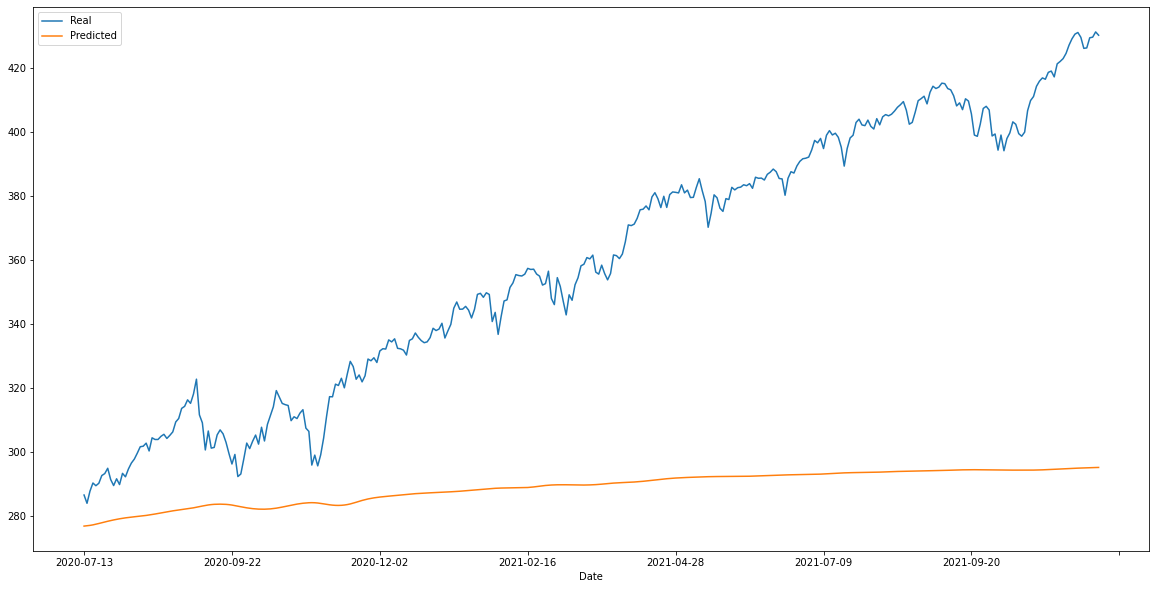

In [160]:
# Plot the real vs predicted values as a line chart
stocks.plot(figsize=(20,10))

In [161]:
stocks["Real_Diff"] = stocks["Real"].pct_change() * 100
stocks["Predicted_Diff"] = stocks["Predicted"].pct_change() * 100
stocks["Real_Signal"] = np.where(stocks["Real_Diff"] >= 0, 1, -1)
stocks["Predicted_Signal"] = np.where(stocks["Predicted_Diff"] >= 0, 1, -1)
stocks["Result"] = stocks["Real_Signal"] - stocks["Predicted_Signal"]
stocks[stocks['Result'] != 0]

,Real,Predicted,Real_Diff,Predicted_Diff,Real_Signal,Predicted_Signal,Result
Date,,,,,,,
2020-07-14,283.855316,276.815674,-0.904745,0.034392,-1,1,-2
2020-07-17,289.362427,277.302643,-0.290899,0.072598,-1,1,-2
2020-07-24,291.296265,278.442627,-1.195361,0.076652,-1,1,-2
2020-07-27,289.411530,278.646088,-0.647017,0.073075,-1,1,-2
2020-07-29,289.715820,279.003967,-0.619601,0.061297,-1,1,-2
...,...,...,...,...,...,...,...
2021-10-25,416.589996,294.363861,-0.100720,0.012791,-1,1,-2
2021-10-28,417.329987,294.492645,-0.434214,0.015366,-1,1,-2
2021-11-10,429.720001,294.895905,-0.350163,0.012565,-1,1,-2


In [162]:
#Accuracy
matches = len(stocks[stocks['Result'] == 0])
accuracy = len(stocks[stocks['Result'] == 0])/len(stocks)*100

print(f'Total Results = {len(stocks)}')
print(f'Matched Results = {matches}')
print(f'Accuracy = {accuracy}')

Total Results = 344
Matched Results = 196
Accuracy = 56.97674418604651
